In [1]:
# ============================================
# Part 1: Load data, define Voigt profile, model
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import wofz
from scipy.integrate import trapezoid

# --- Load data ---
file_path = r'../PyExoCross/data/xsecs/files/H2O/HITRAN/H2O__T2100__wl2333-2335nm__uncNone__thres1e-45__HITRAN__Ab__BinSize3.0303030303030302e-05nm__SciPyVoigt.xsec'
data = np.loadtxt(file_path)
x_nm = data[:,0]; y = data[:,1]
mask = (x_nm >= 2334.0) & (x_nm <= 2334.25)
x_nm = x_nm[mask]; y = y[mask]

def nm_to_wn(nm): return 1e7/nm
x_wn = nm_to_wn(x_nm)

# --- Two superlines (center [cm^-1], starting amplitude) ---
line1 = [4.28410552e3, 4.42230484e-23]
line2 = [4.28420406e3, 6.36810713e-23]
c1_fixed, c2_fixed = line1[0], line2[0]
a1_guess, a2_guess = line1[1], line2[1]

# --- Voigt profile ---
def voigt_wn(x, center, amplitude, sigma, gamma):
    z = ((x - center) + 1j*gamma) / (sigma * np.sqrt(2))
    return amplitude * np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

def softplus(w): return np.log1p(np.exp(-np.abs(w)))+np.maximum(w,0)
def inv_softplus(target): return np.log(np.expm1(max(target,1e-12)))
def softshift(raw, limit=0.01): return limit*np.tanh(raw)

# --- Model with shared sigma + soft-bounded shifts ---
def two_voigt_shared_sigma_shift_soft(x, a1, g1_raw, a2, g2_raw, s_raw, d1_raw, d2_raw):
    g1 = softplus(g1_raw); g2 = softplus(g2_raw); sigma = softplus(s_raw)
    d1 = softshift(d1_raw,0.01); d2 = softshift(d2_raw,0.01)
    c1 = c1_fixed+d1; c2 = c2_fixed+d2
    return voigt_wn(x,c1,a1,sigma,g1)+voigt_wn(x,c2,a2,sigma,g2)
    

In [2]:
# ============================================
# Part 2: Fit parameters and find inflection points
# ============================================

# --- Fit ---
p0=[a1_guess,inv_softplus(0.02),a2_guess,inv_softplus(0.02),inv_softplus(0.03),0.0,0.0]
popt,_=curve_fit(two_voigt_shared_sigma_shift_soft,x_wn,y,p0=p0,maxfev=30000)

a1,g1_raw,a2,g2_raw,s_raw,d1_raw,d2_raw=popt
sigma=softplus(s_raw); g1=softplus(g1_raw); g2=softplus(g2_raw)
d1=softshift(d1_raw,0.01); d2=softshift(d2_raw,0.01)
c1_fit=c1_fixed+d1; c2_fit=c2_fixed+d2

print(f"a1={a1:.3e}, a2={a2:.3e}, sigma={sigma:.3e}, g1={g1:.3e}, g2={g2:.3e}")
print(f"centers: c1={c1_fit:.5f}, c2={c2_fit:.5f}")

# --- Profiles ---
y_total=two_voigt_shared_sigma_shift_soft(x_wn,*popt)
y1=voigt_wn(x_wn,c1_fit,a1,sigma,g1)
y2=voigt_wn(x_wn,c2_fit,a2,sigma,g2)

# --- Inflection points ---
def inflection_bounds(x,y,center):
    dy=np.gradient(y,x); d2y=np.gradient(dy,x)
    i0=np.argmin(np.abs(x-center))
    iL,iR=None,None
    for i in range(i0-1,1,-1):
        if np.sign(d2y[i])!=np.sign(d2y[i-1]): iL=i; break
    for i in range(i0+1,len(x)-1):
        if np.sign(d2y[i])!=np.sign(d2y[i-1]): iR=i; break
    def refine(i):
        x1,x2=x[i-1],x[i]; y1_,y2_=d2y[i-1],d2y[i]
        t=-y1_/(y2_-y1_) if (y2_-y1_)!=0 else 0.5
        return x1+t*(x2-x1)
    xL=refine(iL) if iL else x[i0-5]; xR=refine(iR) if iR else x[i0+5]
    return xL,xR

xL1,xR1=inflection_bounds(x_wn,y1,c1_fit)
xL2,xR2=inflection_bounds(x_wn,y2,c2_fit)

print(f"Line1 inflection bounds: {xL1:.5f}, {xR1:.5f}")
print(f"Line2 inflection bounds: {xL2:.5f}, {xR2:.5f}")

# --- FWHM and integrals ---
def voigt_fwhm_cm1(sigma, gamma):
    return 0.5346*gamma + np.sqrt(0.2166*gamma**2 + 8*np.log(2)*sigma**2)
#note from https://www.mdpi.com/2571-6182/7/2/23
#(𝛾_𝐿 and 𝛾_𝐺 are the HWHM (half with at half maximum) values of the Lorentzian and Gaussian profiles, respectively
# Approximation with an accuracy of 0.02% was given by Olivero et al. [51] 
#(originally found by Kielkopf [52]):𝛾_V≈0.5346𝛾_L+√0.2166𝛾2_L+𝛾2_G(35)
#Expression (35) is also exact for a pure Gaussian or Lorentzian.    

def line_integral(center, a, s, g):
    fwhm = voigt_fwhm_cm1(s, g)
    x_int = np.linspace(center - fwhm/2, center + fwhm/2, 600)
    y_int = voigt_wn(x_int, center, a, s, g)
    area = trapezoid(y_int, x_int)
    return fwhm, area, x_int, y_int

fwhm1, area1, x1_int, y1_int = line_integral(c1_fit, a1, sigma, g1)
fwhm2, area2, x2_int, y2_int = line_integral(c2_fit, a2, sigma, g2)

print(f"Line1 HWHM={fwhm1:.3e} cm^-1, Integral={area1:.3e}")
print(f"Line2 HWHM={fwhm2:.3e} cm^-1, Integral={area2:.3e}")

a1=5.337e-23, a2=9.652e-23, sigma=4.845e-06, g1=3.894e-02, g2=6.634e-02
centers: c1=4284.10979, c2=4284.20983
Line1 inflection bounds: 4284.13227, 4284.08731
Line2 inflection bounds: 4284.24813, 4284.17153
Line1 HWHM=3.894e-02 cm^-1, Integral=1.575e-23
Line2 HWHM=6.634e-02 cm^-1, Integral=2.849e-23


In [3]:
# ============================================
# Part 3a: Compute integrals and ratios
# ============================================

def area_inflection_total_and_trimmed(center, a, s, g, xL, xR, npts=800):
    # Zajisti správné pořadí inflexních bodů
    if xL > xR:
        xL, xR = xR, xL

    xi = np.linspace(xL, xR, npts)
    yi = voigt_wn(xi, center, a, s, g)

    # Celková plocha pod křivkou
    area_total = trapezoid(yi, xi)

    # Baseline = min hodnoty profilu v inflexních bodech
    yL = voigt_wn(xL, center, a, s, g)
    yR = voigt_wn(xR, center, a, s, g)
    baseline = min(yL, yR)

    # Odečtení obdélníku pod baseline
    rect = (xR - xL) * baseline
    trimmed_area = area_total - rect

    # Pojistka proti záporným hodnotám
    eps = 1e-30
    area_total = max(area_total, eps)
    trimmed_area = max(trimmed_area, eps)

    return area_total, trimmed_area, xi, yi, baseline

area1_total, area1_trim, xi1, yi1, base1 = area_inflection_total_and_trimmed(c1_fit, a1, sigma, g1, xL1, xR1)
area2_total, area2_trim, xi2, yi2, base2 = area_inflection_total_and_trimmed(c2_fit, a2, sigma, g2, xL2, xR2)

# Bezpečné poměry
ratio_total = area1_total / area2_total if area2_total > 0 else float('nan')
ratio_trim = area1_trim / area2_trim if area2_trim > 0 else float('nan')

print(f"Line1 area_total = {area1_total:.3e}, trimmed = {area1_trim:.3e}")
print(f"Line2 area_total = {area2_total:.3e}, trimmed = {area2_trim:.3e}")
print(f"Ratios: total = {ratio_total:.3f}, trimmed = {ratio_trim:.3f}")


Line1 area_total = 1.779e-23, trimmed = 3.078e-24
Line2 area_total = 3.217e-23, trimmed = 5.566e-24
Ratios: total = 0.553, trimmed = 0.553


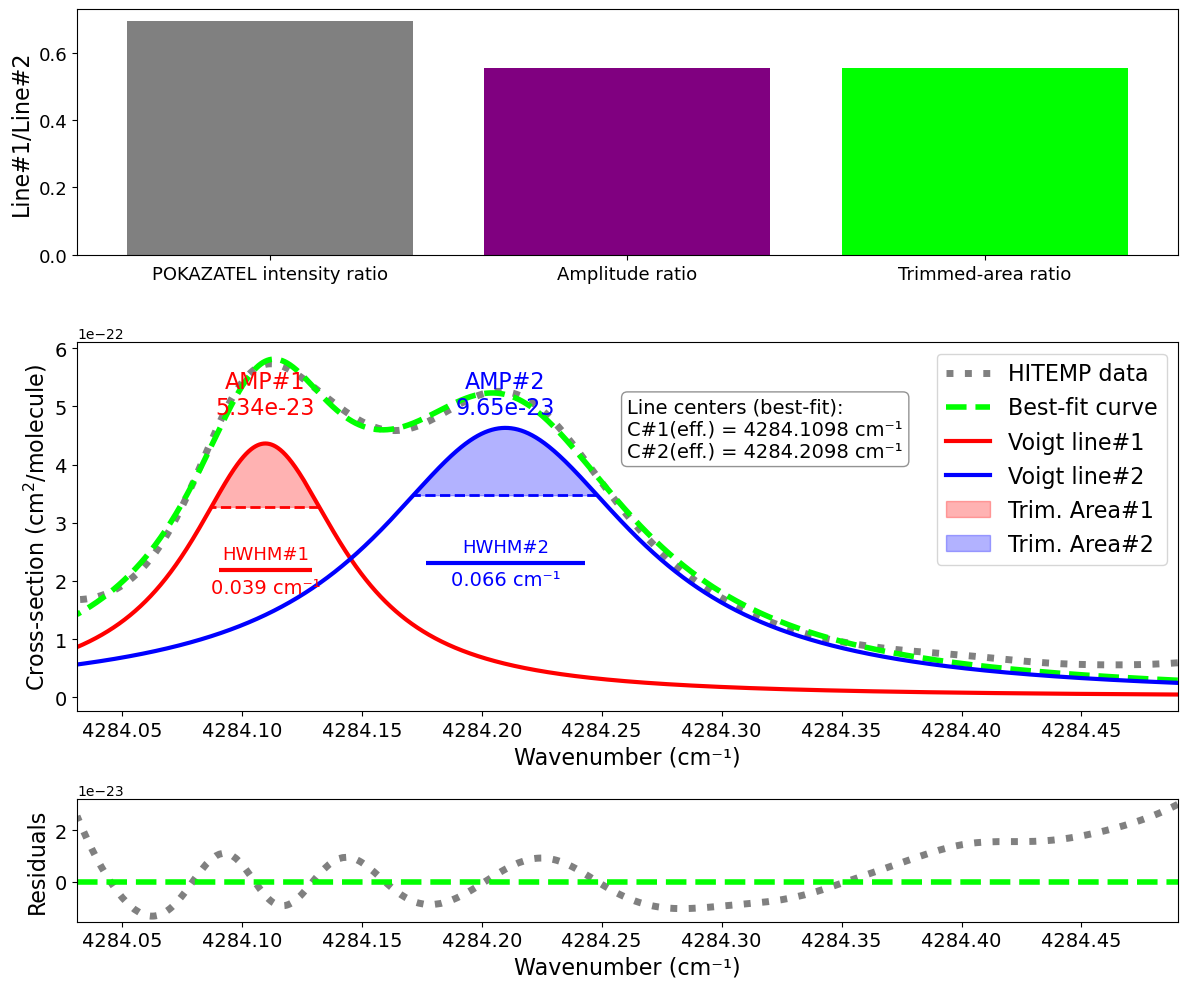

In [5]:
# ============================================
# Part 3b: Visualization of trimmed areas
# ============================================

import matplotlib.ticker as mticker
from math import floor, ceil

fig, (ax3, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 10), gridspec_kw={'height_ratios':[2,3,1]})

# Ratio panel
cats = ['POKAZATEL intensity ratio', 'Amplitude ratio', 'Trimmed-area ratio']
vals = [a1_guess/a2_guess, a1/a2, area1_trim/area2_trim]
ax3.bar(cats, vals, color=['gray', 'purple', 'lime'])
ax3.set_ylabel("Line#1/Line#2", fontsize=16)
ax3.tick_params(axis='both', which='major', labelsize=13)

# Data + fit + components
ax1.plot(x_wn, y, color='grey', ls="dotted", lw=5, label='HITEMP data')
ax1.plot(x_wn, y_total, color='lime', label='Best-fit curve', linewidth=4, linestyle="dashed")
ax1.plot(x_wn, y1, color='red', lw=3, label='Voigt line#1')
ax1.plot(x_wn, y2, color='blue', lw=3, label='Voigt line#2')

# Fill trimmed areas
ax1.hlines(base1, xL1, xR1, colors='red', linestyles='--', linewidth=2)
ax1.fill_between(xi1, yi1, base1, where=(yi1 > base1), color='red', alpha=0.3, label='Trim. Area#1')
ax1.text(c1_fit, max(yi2)*1.15, f"AMP#1", color='red', ha='center', fontsize=16)
ax1.text(c1_fit, max(yi2)*1.05, f"{a1:.2e}", color='red', ha='center', fontsize=16)

ax1.hlines(base2, xL2, xR2, colors='blue', linestyles='--', linewidth=2)
ax1.fill_between(xi2, yi2, base2, where=(yi2 > base2), color='blue', alpha=0.3, label='Trim. Area#2')
ax1.text(c2_fit, max(yi2)*1.15, f"AMP#2", color='blue', ha='center', fontsize=16)
ax1.text(c2_fit, max(yi2)*1.05, f"{a2:.2e}", color='blue', ha='center', fontsize=16)

#ax1.set_title("Deconvoluted Voigt line fits with inflection-point based (trimmed) integrals", fontsize=20)
leg = ax1.legend(loc='best', fontsize=16)

# Axis labels (double-sized) and ticks
ax1.set_xlabel("Wavenumber (cm⁻¹)", fontsize=16)
ax1.set_ylabel("Cross-section (cm$^2$/molecule)", fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)

# Ensure plain integer x-axis ticks (remove scientific offset like +4.2848e3)
sf = mticker.ScalarFormatter(useMathText=False)
sf.set_useOffset(False)
ax1.xaxis.set_major_formatter(sf)

# Restrict to integer ticks within range
xmin, xmax = x_wn.min(), x_wn.max()
ax1.set_xlim(xmin, xmax)
ax1.xaxis.set_major_locator(mticker.MaxNLocator(integer=True, prune='both'))

# Line 1 half-maximum baseline (FWHM line) and HWHM text at baseline level
y0_1 = voigt_wn(c1_fit, c1_fit, a1, sigma, g1)       # peak intensity
y_half_1 = y0_1 / 2.0
x1_fwhm_left = c1_fit - fwhm1/2
x1_fwhm_right = c1_fit + fwhm1/2
ax1.hlines(y_half_1, x1_fwhm_left, x1_fwhm_right, colors='red', linestyles='-', linewidth=3)
ax1.text(c1_fit, y_half_1 + 0.033*y.max(), f"HWHM#1", color='red', ha='center', fontsize=13)
ax1.text(c1_fit, y_half_1 - 0.067*y.max(), f"{fwhm1:.3f} cm⁻¹", color='red', ha='center', fontsize=14)

# Line 2 half-maximum baseline (FWHM line) and HWHM text
y0_2 = voigt_wn(c2_fit, c2_fit, a2, sigma, g2)
y_half_2 = y0_2 / 2.0
x2_fwhm_left = c2_fit - fwhm2/2
x2_fwhm_right = c2_fit + fwhm2/2
ax1.hlines(y_half_2, x2_fwhm_left, x2_fwhm_right, colors='blue', linestyles='-', linewidth=3)
ax1.text(c2_fit, y_half_2 + 0.033*y.max(), f"HWHM#2", color='blue', ha='center', fontsize=13)
ax1.text(c2_fit, y_half_2 - 0.067*y.max(), f"{fwhm2:.3f} cm⁻¹", color='blue', ha='center', fontsize=14)


# Panel with centers under legend, right side
centers_info = (
    f"Line centers (best-fit):\n"
    f"C#1(eff.) = {c1_fit:.4f} cm⁻¹\n"
    f"C#2(eff.) = {c2_fit:.4f} cm⁻¹"
)
ax1.text(
    0.5, 0.85, centers_info,
    transform=ax1.transAxes,
    fontsize=14,
    va='top', ha='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.85, edgecolor='gray')
)

# Residuals
res = y - y_total
ax2.plot(x_wn, res, color='gray',  ls='dotted', lw=5)
ax2.axhline(0, color='lime', ls='--', lw=4)
ax2.set_ylabel("Residuals", fontsize=16)
ax2.set_xlabel("Wavenumber (cm⁻¹)", fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.xaxis.set_major_formatter(sf)
ax2.xaxis.set_major_locator(mticker.MaxNLocator(integer=True, prune='both'))
ax2.set_xlim(xmin, xmax)

plt.tight_layout()
plt.show()

# Nastav velikost figure na A4 (portrait)
#fig.set_size_inches(8.27, 11.69)

# Uložení do PDF
fig.savefig("voigt_plot.pdf", format="pdf", bbox_inches="tight")